# Event location MORA SUs

This notebook takes the phase pickin from phasePicking_MORA notebook and does a simple grid search location if the event epicenter and centroid and save it into a second data frame.

Done by Marine Denolle (mdenolle@uw.edu) on 3/21/2024, with the help of undergraduate student Francesca Skene.

In [1]:
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# import scipy
# from scipy import optimize
# from scipy.optimize import curve_fit
# from datetime import datetime
from utils import *
# import torch
# plt.rcParams.update({'font.size': 10})



# from joblib import Parallel, delayed
# from matplotlib.backends.backend_pdf import PdfPages
# import pyproj

In [2]:
# odd parameters

t_before = 15 #number of seconds before pick time

## Volcano Data

In [3]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('../data/station/Volcano_Metadata_50km.csv')

In [4]:
associated_volcano = 'Mt_Rainier'
        
#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()


In [5]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5]
#Find the lower left corner and grid size based on volcano elevation
# define grid origin in lat,lon and grid dimensions in m
lon_start = -122 #volc_lat_lon[associated_volcano][0]
lon_end = -121.5 #volc_lat_lon[associated_volcano][0]
lat_start = 46.6 #volc_lat_lon[associated_volcano][1]
lat_end = 47 #volc_lat_lon[associated_volcano][1]


## read pick data

In [14]:
dff=pd.read_csv("../data/events/MLPicks_MtRainier.csv")

# unique event IDS
evtID_uniques = np.unique(dff['event_ID'].values)
event_ID =evtID_uniques[4] # 3180468
############ LOCATION ############################
# input necessary data for grid search
# arrivals = dff['smb_peak'].values
arrivals = dff[dff['event_ID']==event_ID]['smb_peak'].values
centroid = dff[dff['event_ID']==event_ID]['centroid_time'].values
maxtime = dff[dff['event_ID']==event_ID]['max_time'].values
sta_lats = dff[dff['event_ID']==event_ID]['lats'].values
sta_lons = dff[dff['event_ID']==event_ID]['lons'].values
stas = dff[dff['event_ID']==event_ID]['stas'].values   


In [15]:
event_ID

3181383

We should add plots of the waveforms

[2.775 2.8   3.55  4.125 4.5   3.525 6.625 3.3   4.475 1.325 2.775 1.825]


Text(0.5, 1.0, 'Travel time Relative to RCM')

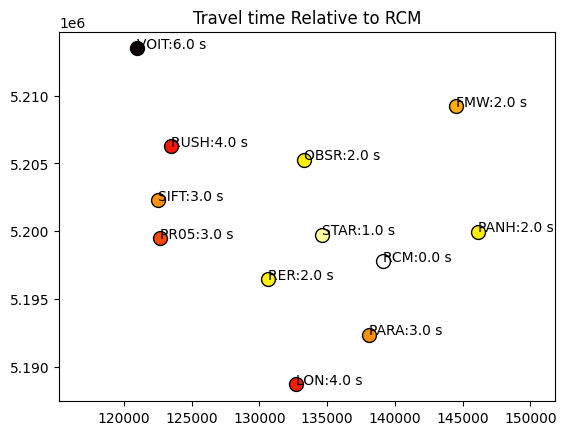

In [16]:
import pyproj


# # Define the projection: UTM zone 11 for Washington state
proj = pyproj.Proj(proj='utm', zone=11, ellps='WGS84')
print(arrivals)
# Convert lat/long to Cartesian in meters
xsta, ysta = proj(sta_lons, sta_lats)
cmap = plt.get_cmap('hot_r')
ik=np.where(arrivals>0)[0]
for i in ik:
    tt = arrivals[i]-np.min(arrivals[ik])
    nmax=np.max(arrivals[ik])-np.min(arrivals[ik])
    plt.plot(xsta[i],ysta[i],'o',color=cmap(tt/nmax),markersize=10,markeredgecolor='k')
    plt.text(xsta[i],ysta[i],stas[i]+":"+str(np.ceil(tt))+" s")
    plt.axis('equal')
plt.title("Travel time Relative to RCM")

## Locations:
1. Event Origin location
2. Event Centroid location
3. Event Max location

In [17]:
ista =np.where(arrivals>+0.1)[0]
crap = arrivals[ista] - np.min(arrivals[ista])
crap = arrivals[ista] - np.min(arrivals[ista])
t_best,lon_best,lat_best = gridsearch_parallel(lat_start,lon_start,\
                                              lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],crap,vs=1000)#,
                                                # weight=dff['snr'].values[ista]**2)



crap = centroid[ista] - np.min(centroid[ista])  
mt_best,mlon_best,mlat_best = gridsearch_parallel(lat_start,lon_start,\
                                              lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],crap,vs=1000)


crap = maxtime[ista] - np.min(maxtime[ista])
ct_best,clon_best,clat_best = gridsearch_parallel(lat_start,lon_start,\
                                              lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],crap,vs=1000)
print("Best origin time & loc",t_best,lon_best,lat_best)
print("Best centroid time & loc",mt_best,mlon_best,mlat_best)
print("Best max time & loc",ct_best,clon_best,clat_best)


5
11
5
Best origin time & loc -3.75 -121.7544518463187 46.89672692269356
Best centroid time & loc -2.25 -121.7468043696094 46.795333627933296
Best max time & loc -3.75 -121.89172573604806 46.81802070758893


In [18]:
mm = np.sign(np.mean(centroid[ista] - maxtime[ista]))
# if mm<0: centroid is before max

Is the centroid before or after the max?

(-122.0004404, -121.6255516, 46.73981245, 46.97711655)

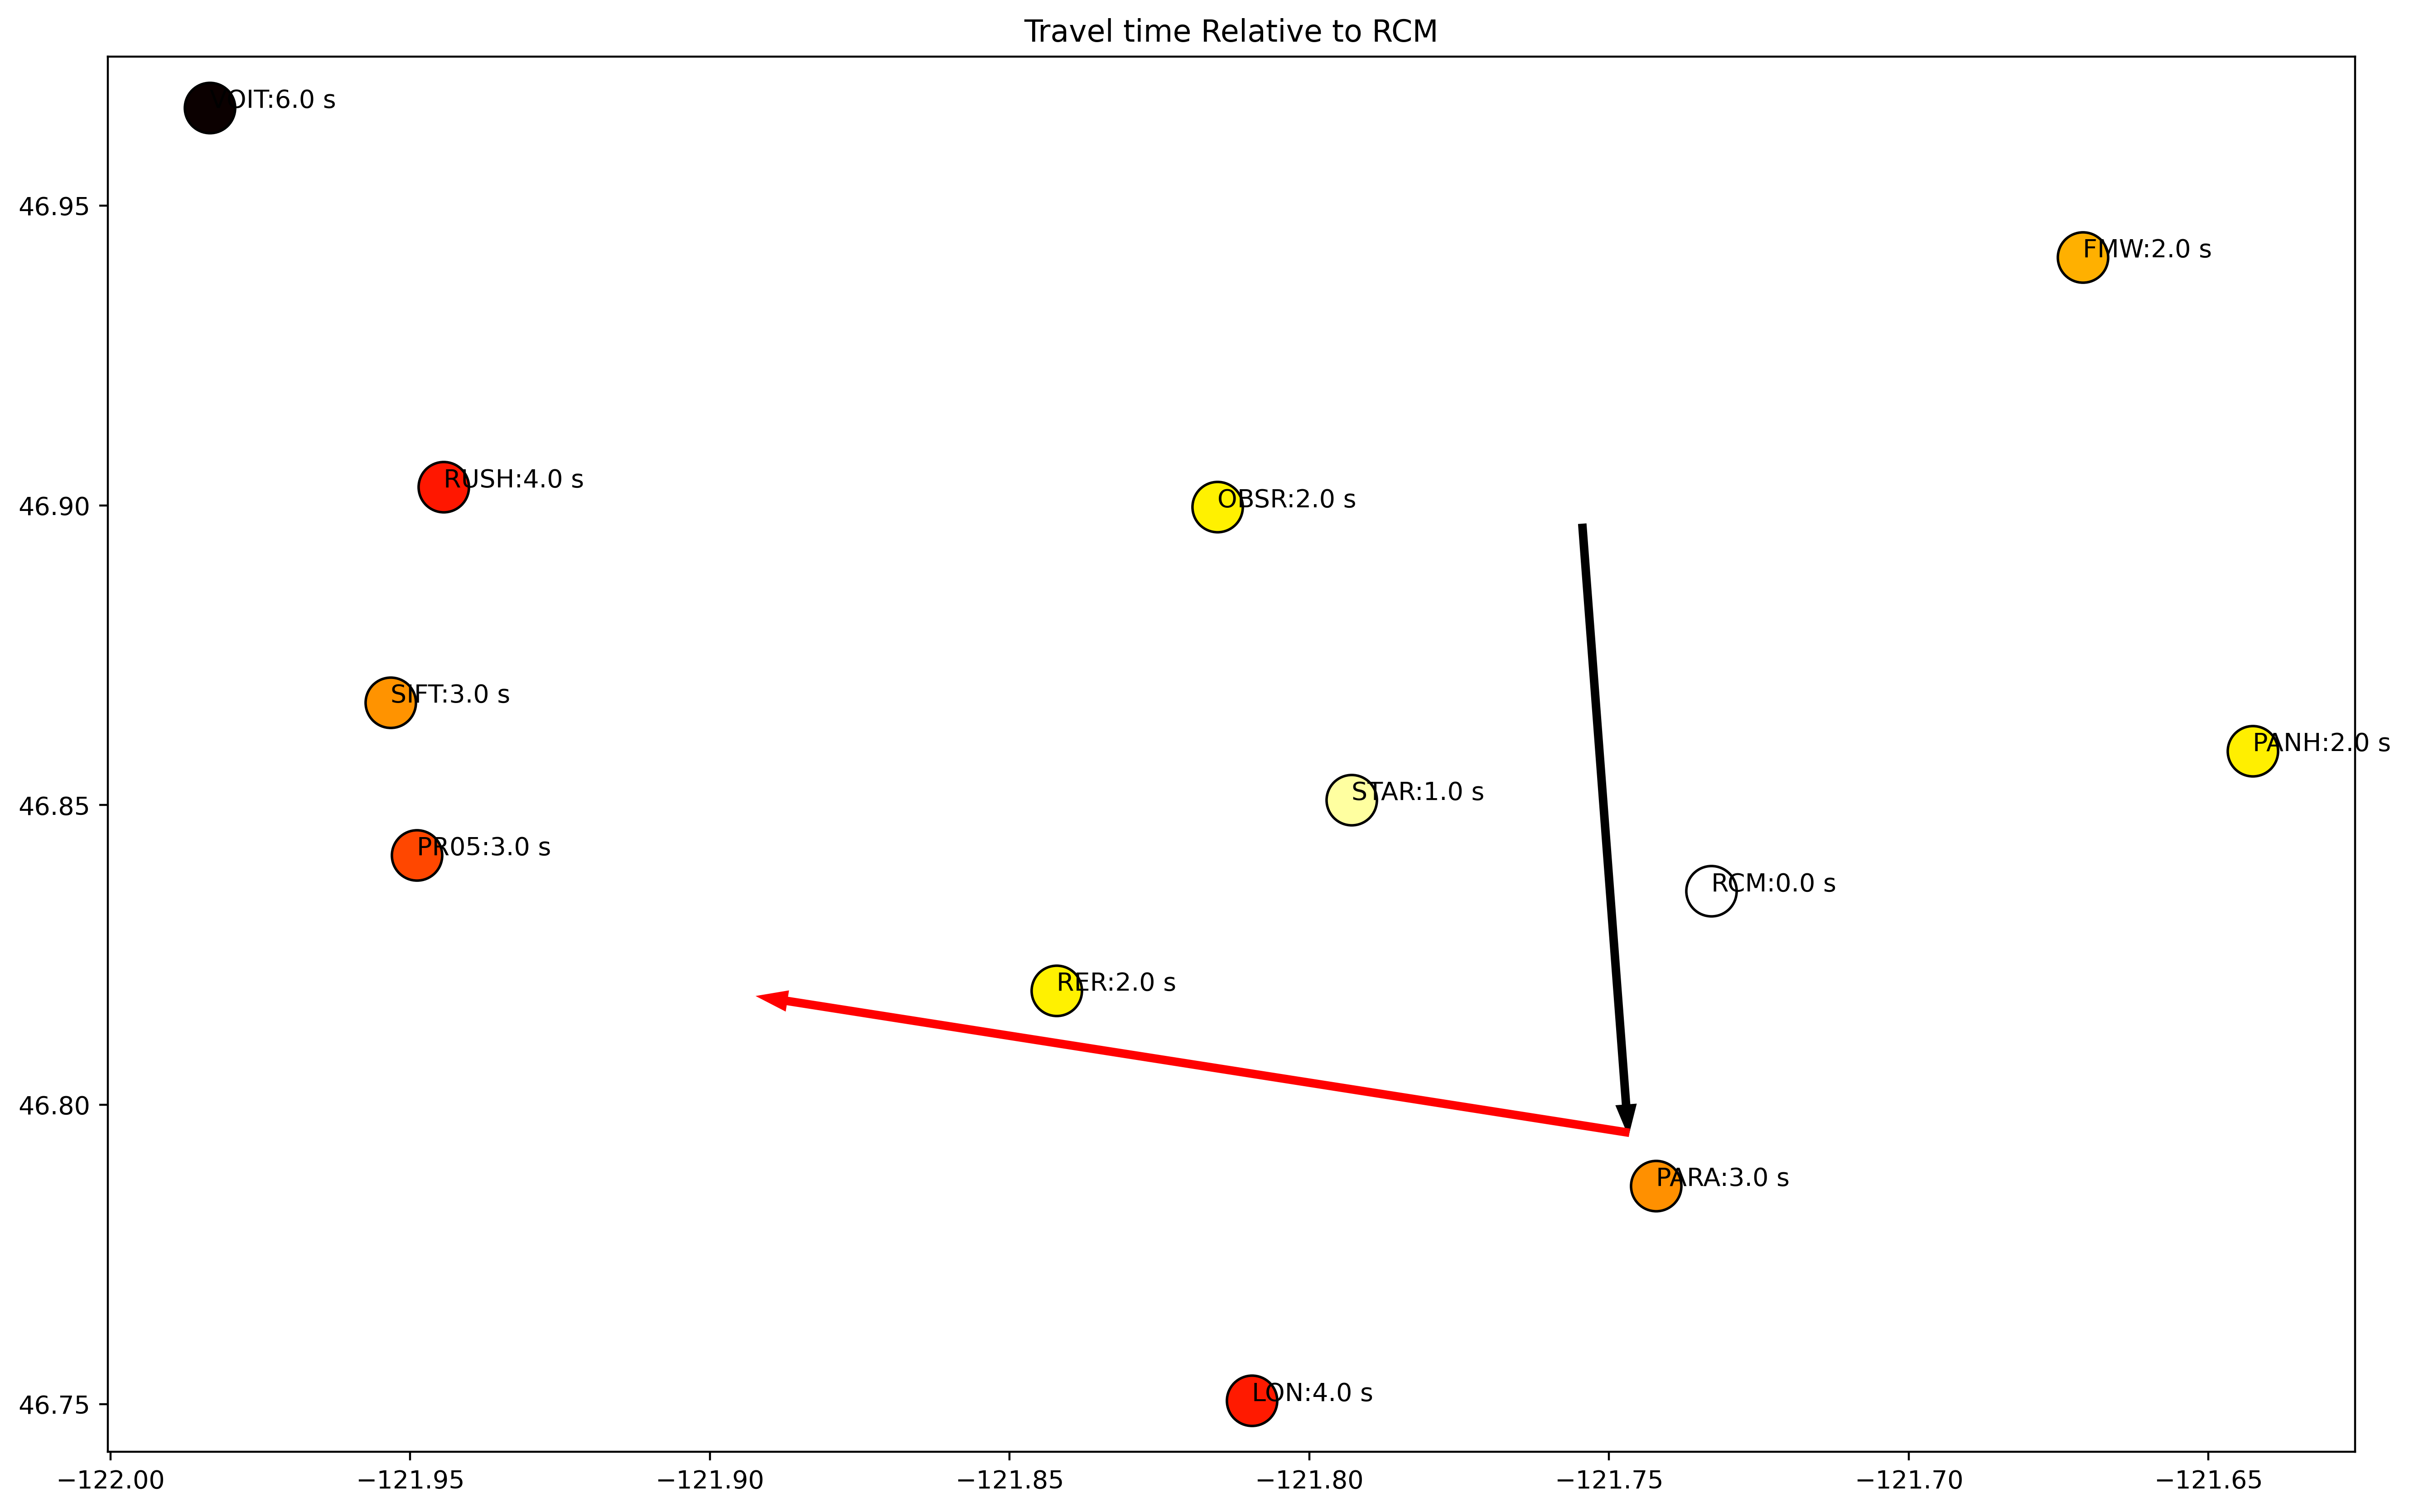

In [19]:
# Existing imshow plot
fig, ax = plt.subplots(figsize=(16, 10), dpi=400)
# im = plt.imshow(np.squeeze(rss_mat[0,:,:].T),extent=[lon_start,lon_end,lat_start,lat_end], cmap='hsv', interpolation='nearest',origin='lower')

# Add contour lines
num_contour_lines = 20  # Change this to the number of contour lines you want
# contours = plt.contour(np.squeeze(rss_mat[0,:,:].T), num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
# plt.clabel(contours, inline=True, fontsize=8)
if mm>0:
    plt.arrow(lon_best, lat_best, mlon_best - lon_best, mlat_best - lat_best, color='k', length_includes_head=True)
    plt.arrow(mlon_best, mlat_best, clon_best - mlon_best, clat_best - mlat_best, color='r', length_includes_head=True)
else:
    plt.arrow(lon_best, lat_best, clon_best - lon_best, clat_best - lat_best, color='k', length_includes_head=True)
    plt.arrow(clon_best, clat_best, mlon_best - clon_best, mlat_best - clat_best, color='r', length_includes_head=True)
    
cmap1 = plt.get_cmap('hot_r')
ik=np.where(arrivals>0)[0]
for i in ik:
    tt = arrivals[i]-np.min(arrivals[ik])
    nmax=np.max(arrivals[ik])-np.min(arrivals[ik])
    plt.plot(sta_lons[i],sta_lats[i],'o',color=cmap1(tt/nmax),markersize=20,markeredgecolor='k')
    plt.text(sta_lons[i],sta_lats[i],stas[i]+":"+str(np.ceil(tt))+" s")
plt.title("Travel time Relative to RCM")
plt.xlim([-122,-121]);
plt.axis('equal')



ok, the location works but seems quite innacurate: why is the location not closer to the first stations that saw it?
We will do a bootstrap grid search and find an enemble of solution and take the median location.

In [ ]:
# ista =np.where(arrivals>-t_before+0.1)[0]
# # Number of bootstrap samples
# n_bootstrap = 100

# # Initialize an array to hold the bootstrap results
# bootstrap_results = []
# llon_best=np.zeros(n_bootstrap)
# llat_best=np.zeros(n_bootstrap)
# for ii in range(n_bootstrap):
#     # Generate a bootstrap sample from ista
#     ista_sample = np.random.choice(ista, size=len(ista), replace=True)
#     # ista_sample=ista
#     # Perform the grid search with the bootstrap sample
#     t_best, lon_best, lat_best = gridsearch_parallel(lat_start, lon_start, lat_end, lon_end,\
#                                                                 sta_lats[ista_sample], sta_lons[ista_sample],\
#                                                                     arrivals[ista_sample])

#     # Store the results
#     llon_best[ii] = lon_best
#     llat_best[ii] = lat_best
#     print(llat_best[ii],llon_best[ii])
#     break
# bootstrap_lon_best=np.mean(llon_best)
# bootstrap_lat_best=np.mean(llat_best)
    

After some experimentation, we find that the locations found by the grid search are highly dependent on the choice of stations used. Weighting with the SNR brings even more variability.

In [ ]:
# # Existing imshow plot
# fig, ax = plt.subplots(figsize=(16, 10), dpi=400)
# im = plt.imshow(np.squeeze(rss_mat[0,:,:].T),extent=[lon_start,lon_end,lat_start,lat_end], cmap='hsv', interpolation='nearest',origin='lower')

# # Add contour lines
# num_contour_lines = 20  # Change this to the number of contour lines you want
# contours = plt.contour(np.squeeze(rss_mat[0,:,:].T), num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
# plt.clabel(contours, inline=True, fontsize=8)
# plt.plot(llon_best,llat_best,'o',color='k',markersize=6)
# plt.plot(bootstrap_lon_best,bootstrap_lat_best,'o',color='k',markersize=10)
# cmap1 = plt.get_cmap('hot_r')
# ik=np.where(arrivals>0)[0]
# for i in ik:
#     tt = arrivals[i]-np.min(arrivals[ik])
#     nmax=np.max(arrivals[ik])-np.min(arrivals[ik])
#     plt.plot(sta_lons[i],sta_lats[i],'o',color=cmap1(tt/nmax),markersize=dff[dff['stas']==stas[i]]['snr'].values,markeredgecolor='k')
#     plt.text(sta_lons[i],sta_lats[i],stas[i]+":"+str(np.ceil(tt))+" s")
# plt.title("Travel time Relative to RCM, marker size shows SNR of waveform")
# plt.xlim([-122,-121.5]);



Overlay with the travel time to compare with the observations

In [ ]:
# # given the source location, calculate travel times
# proj = pyproj.Proj(proj='utm', zone=11, ellps='WGS84')

# if lon_start<0: 
#     lon_start1 = lon_start+360
#     lon_end1 = lon_end + 360

# # Convert lat/long to Cartesian in meters
# x_step=100
# x1,y1=proj(lon_start,lat_start)
# x2,y2=proj(lon_end,lat_end)
# su_x,su_y=proj(lon_best,lat_best)
# # Generate the x and y coordinates for the grid
# x_coords = np.arange(x1, x2, x_step)
# y_coords = np.arange(y1, y2, x_step)
# vs=3000
# synthetic_tt = np.zeros((len(x_coords),len(y_coords)))    
# for i in range(len(x_coords)):
#     for j in range(len(y_coords)):
#         synthetic_tt[i,j] = np.sqrt( (x_coords[i] - su_x  )**2 + (y_coords[j] - su_y)**2  ) / vs 
    


In [ ]:
# # Existing imshow plot
# fig, ax = plt.subplots(figsize=(16, 10), dpi=400)
# im = plt.imshow(np.squeeze(rss_mat[0,:,:].T),extent=[lon_start,lon_end,lat_start,lat_end], cmap='hsv', interpolation='nearest',origin='lower')


# # Add contour lines
# num_contour_lines = 20  # Change this to the number of contour lines you want

# contours = plt.contour(synthetic_tt.T, num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
# # contours = plt.contour(np.squeeze(rss_mat[0,:,:].T), num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
# # contours = plt.contour(synthetic_tt, num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
# plt.clabel(contours, inline=True, fontsize=8)
# # plt.plot(bootstrap_lon_best,bootstrap_lat_best,'o',color='k',markersize=10)
# cmap1 = plt.get_cmap('hot_r')
# ik=np.where(arrivals>0)[0]
# for i in ik:
#     tt = arrivals[i]-np.min(arrivals[ik])
#     nmax=np.max(arrivals[ik])-np.min(arrivals[ik])
#     plt.plot(sta_lons[i],sta_lats[i],'o',color=cmap1(tt/nmax),markersize=dff[dff['stas']==stas[i]]['snr'].values,markeredgecolor='k')
#     plt.text(sta_lons[i],sta_lats[i],stas[i]+":"+str(np.ceil(tt))+" s")

# plt.plot(lon_best,lat_best,'o',color='k',markersize=10)
# plt.title("Travel time Relative to RCM, marker size shows SNR of waveform")
# plt.xlim([-122,-121.5]);



## Now consider weighing with the DEM

In [ ]:
# #DEM data 
# import rasterio as rio
# dem = rio.open('../data/geospatial/Mt_Rainier/Mt_Rainier.tif') #washington volcanoes
# dem_array = dem.read(1).astype('float64')
# dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
# crs = dem.crs
# #     else:
# #         dem = rio.open('Data/DEM_data/'+str(name)+'/_w001001.adf') #oregon volcanoes
# #         dem_array = dem.read(1).astype('float64')
# #         dem_array[dem_array == -3.4028234663852886e+38] = np.nan #gets rid of edge effects
# #         crs = dem.crs
# # #     volc = rd.rdarray(dem_array, no_data=-9999)
# #     slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
# #     aspect = rd.TerrainAttribute(volc, attrib = 'aspect')
# #     dem_data_dict[name] = {'data':dem_array, 'elevation':volc, 'slope':slope, 'aspect':aspect}
# dem_data_dict={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [ ]:
# # Plot the data
# plt.imshow(dem_array, cmap='gray')
# plt.show()

We need to reproject the DEM onto our own grid (x_coord, y_coord)s

In [ ]:
# from rasterio.warp import reproject, Resampling

# new_transform = rio.transform.from_origin(-180, 90, 0.1, 0.1)  # Change this to your desired grid
# new_crs = dem.crs  # Use the same CRS as the input data
# new_shape = (1800, 3600)  # Change this to your desired shape

# # Create an output array
# output_data = np.empty(new_shape, dtype=dem_array.dtype)

# # Reproject the data
# reproject(
#     input_data,
#     output_data,
#     src_transform=src.transform,
#     src_crs=src.crs,
#     dst_transform=new_transform,
#     dst_crs=new_crs,
#     resampling=Resampling.nearest)


In [ ]:

# #making plots of directivity and location
# crs = dem_data_dict[associated_volcano]['crs']
# data = dem_data_dict[associated_volcano]['data']
# info = volc_lat_lon[associated_volcano]
# p2 = Proj(crs,preserve_units=False)
# p1 = Proj(proj='latlong',preserve_units=False)
# # gives the lower left grid point in the grid search
# left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# # gives the left right, bottom, top of the grid
# grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
# left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
# bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']
# contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
# center_x, center_y = transform(p1,p2,info[1],info[0])
# loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)
# duration=avg_duration
# length_factor = duration/100

# fig,ax = plt.subplots(1,1,figsize=(8,11), dpi = 200)
# a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth')
# contours = ax.contour(contour_x,contour_y,np.log10(rss_mat[int(loc_idx[0]),:,:].T),cmap='plasma')
# ax.scatter(center_x, center_y, s=100,marker='*',c='r')
# plt.arrow(loc_x,loc_y,dy*length_factor,dx*length_factor, color='w', width=170, label='no weight')
# plt.arrow(loc_x,loc_y,dy_sharp*length_factor,dx_sharp*length_factor, color='k', width=170, label='sharpness')
# plt.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='m', width=170, label='snr')
# #plotting the stations on top of this as triangles
# for i, ii in enumerate(stas):
#     sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
#     if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
#         ax.plot(sta_x,sta_y, c='k', marker="^")
#         ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

# #getting lat and lon tick marks on the axis
# tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
# tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
# ticks_x = []
# ticks_y = []
# for i in range(len(tick_lons)):
#     tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
#     ticks_x.append(tick_x)
#     ticks_y.append(tick_y)
#     tick_lons[i]=str(tick_lons[i])
#     tick_lats[i]=str(tick_lats[i])
# divider = make_axes_locatable(ax)
# cax1 = divider.append_axes('right', size='4%', pad=0.1)
# cax2 = divider.append_axes('right', size='4%', pad=1.3)
# ax.set_title('Location and Directivity', fontsize = 20)
# ax.set_xlabel('longitudes(DD)', fontsize = 15)
# ax.set_ylabel('latitudes(DD)', fontsize = 15)
# ax.set_xticks(ticks_x)
# ax.set_xticklabels(tick_lons, fontsize = 15)
# ax.set_yticks(ticks_y)
# ax.set_yticklabels(tick_lats, fontsize = 15)
# ax.clabel(contours)
# cbar = plt.colorbar(a, cax=cax1)
# cbar.ax.tick_params(labelsize=10)
# cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 15)
# cbar2 = plt.colorbar(contours, cax=cax2)
# cbar2.ax.tick_params(labelsize=10)
# cbar2.set_label('RMS error on location\n', rotation=270, labelpad = 13,fontsize = 15)
# ax.set_xlim(left+info[3],right-info[4])
# ax.set_ylim(bottom+info[5],top-info[6])
# ax.legend(fontsize = 12)
# plt.tight_layout()
# plt.savefig('loc_direction'+ event_ID+associated_volcano+'.png',bbox_inches="tight")

# # make a dataframe of the data

In [ ]:
# # Determine the avg slope value within one step of the grid search model
# associated_volcano = 'Mt_Rainier'
# step_gs = 100 # grid search model step size is 100m

# # plot DEM
# crs = r_dem_data_dict[associated_volcano]['crs']
# data = r_dem_data_dict[associated_volcano]['data']
# volc = rd.rdarray(data, no_data=-9999)
# slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
# info = volc_lat_lon[associated_volcano]
# p2 = Proj(crs,preserve_units=False)
# p1 = Proj(proj='latlong',preserve_units=False)
# # gives the lower left grid point in the grid search
# left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# # gives the left right, bottom, top of the grid
# grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
# left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
# bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']
# contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
# center_x, center_y = transform(p1,p2,info[1],info[0])
# loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)

# # looking at where the grid is:
# x = np.linspace(left_x, left_x+25000, 10)
# y = np.linspace(bottom_y, bottom_y+25000, 10)

### SLOPE

In [ ]:
# a = int((left_x-left)/10)
# b = a+2500
# c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
# d = slope.shape[0] - int((bottom_y-bottom)/10)

# x = np.arange(a,b,1)
# y = np.arange(c,d,1)

# x2 = np.arange(a,b,10) # every 100m
# y2 = np.arange(c,d,10) # every 100m

# slope_data = np.array(slope[c:d,a:b])

In [ ]:
# slope_norm1 = slope_data/np.max(slope_data)

# slope_interp_mat = RectBivariateSpline(y,x,slope_norm1, s = 0)
# interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.9+.1

# rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
# loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
# loc_lat_slope, loc_lon_slope, j = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)


In [ ]:
# plt.rcParams.update({'font.size': 5})

# # weighted by SNR
# weight = np.array(SNR_weight)/np.max(SNR_weight)
# rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
# loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)
# loc_lat, loc_lon, j = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)

# x2 = np.linspace(a,b,250)
# y2 = np.linspace(c,d,250)

# # weighted by SNR and Slope
# rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
# loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
# loc_lat_slope, loc_lon_slope, j = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

# # unweighted
# no_weight = [1,1,1,1,1,1,1,1]
# rss_mat_nw = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,no_weight)
# loc_idx_nw = np.unravel_index([np.argmin(rss_mat_nw)], rss_mat_nw.shape)
# loc_lat_nw, loc_lon_nw, j = location(x_vect[loc_idx_nw[1]], y_vect[loc_idx_nw[2]], lat_start, lon_start)


# # plotting the results
# fig,ax = plt.subplots(3,1,figsize=(6,9), dpi = 180)

# ax[0].set_title('weighted by SNR: '+str(round(loc_lat,3))+','+str(round(loc_lon,3)))
# ax[0].scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
# im0 = ax[0].imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
# #im0 = ax[0].imshow(rss_mat[loc_idx[0],:,:].T,origin="lower",extent=[0,side_length,0,side_length])
# ax[0].set_ylabel('(m)')
# ax[0].set_ylabel('(m)')
# cbar0 = plt.colorbar(im0, ax = ax[0])
# cbar0.ax.tick_params()
# cbar0.set_label('RMS error on location', rotation=270)

# ax[1].set_title('weighted by SNR and Slope: '+str(round(loc_lat_slope,3))+','+str(round(loc_lon_slope,3)))
# ax[1].scatter(x_vect[loc_idx_slope[1]],y_vect[loc_idx_slope[2]],s=100,marker='*',c='r')
# im1 = ax[1].imshow(np.log10(rss_mat_slope[0,:,:].T),origin="lower",extent=[0,side_length,0,side_length])
# #im1 = ax[1].imshow(rss_mat_slope[0,:,:].T,origin="lower",extent=[0,side_length,0,side_length])
# ax[1].set_ylabel('(m)')
# ax[1].set_ylabel('(m)')
# cbar1 = plt.colorbar(im1, ax = ax[1])
# cbar1.ax.tick_params()
# cbar1.set_label('RMS error on location', rotation=270)

# ax[2].set_title('unweighted: '+str(round(loc_lat_nw,3))+','+ str(round(loc_lon_nw,3)))
# ax[2].scatter(x_vect[loc_idx_nw[1]],y_vect[loc_idx_nw[2]],s=100,marker='*',c='r')
# im2 = ax[2].imshow(np.log10(rss_mat_nw[0,:,:].T),origin="lower",extent=[0,side_length,0,side_length])
# #im2 = ax[2].imshow(rss_mat_nw[0,:,:].T,origin="lower",extent=[0,side_length,0,side_length])
# ax[2].set_ylabel('(m)')
# ax[2].set_ylabel('(m)')
# cbar2 = plt.colorbar(im2, ax = ax[2])
# cbar2.ax.tick_params()
# cbar2.set_label('RMS error on location', rotation=270)

In [ ]:



#         # carry out the gridsearch weighted by SNR
#         weight = np.array(SNR_weight)/np.max(SNR_weight)
#         rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
#         loc_idx_snr = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

#         # gridsearch with no weight
#         weight = [1 for i in range(len(SNR_weight))]
#         rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
#         loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

#         # gridsearch weighted with SNR and Slope
#         # plot DEM
#         # gives the lower left grid point in the grid search
#         # gives the left right, bottom, top of the grid
#         left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
#         bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']

#         crs = dem_data_dict[associated_volcano]['crs']
#         data = dem_data_dict[associated_volcano]['data']
#         volc = rd.rdarray(data, no_data=-9999)
#         slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
#         info = volc_lat_lon[associated_volcano]
#         p2 = Proj(crs,preserve_units=False)
#         p1 = Proj(proj='latlong',preserve_units=False)
#         # gives the lower left grid point in the grid search
#         left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
#         # gives the left right, bottom, top of the grid
#         grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
#         left, right = r_dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
#         bottom, top = r_dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

#         a = int((left_x-left)/10)
#         b = a+2500
#         c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
#         d = slope.shape[0] - int((bottom_y-bottom)/10)

#         x = np.arange(a,b,1)
#         y = np.arange(c,d,1)

#         x2 = np.arange(a,b,10) # every 100m
#         y2 = np.arange(c,d,10) # every 100m

#         slope_data = np.array(slope[c:d,a:b])


#         slope_norm1 = slope_data/np.max(slope_data)

#         slope_interp_mat = RectBivariateSpline(y,x,slope_norm1, s = 0)
#         interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.9+.1

#         rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
#         loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
#         loc_lat_slope, loc_lon_slope, test_d = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

#         # plot heatmap
# #         fig,ax = plt.subplots(1,1,figsize=(8,8), dpi = 200)
# #         ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
# #         im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
# #         ax.set_ylabel('(m)')
# #         ax.set_ylabel('(m)')
# #         cbar = plt.colorbar(im)
# #         cbar.ax.tick_params()
# #         cbar.set_label('RMS error on location', rotation=270)
# #         plt.savefig('heatmap'+ event_ID+associated_volcano+'.png')


#         # find the latitude and longitude of the location index
#         loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
#         err_thr = np.min(np.log10(rss_mat))+.05
#         thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
#         diameter = error_diameter(thr_array)

#         break
#         # calculating azimuth for each station with respect to the middle of the volcano
#         for i in range(len(stas)):
#             u,b,c = (gps2dist_azimuth(loc_lat, loc_lon, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
#             r.append(u)
#             theta.append(b)

#         bin1,bin2,bin3 = [],[],[]
#         for i in theta:
#             if 0<=i<=120:
#                 bin1.append(i)
#             if 121<=i<=240:
#                 bin2.append(i)
#             if 241<=i<=360:
#                 bin3.append(i)

#         if bin1 == [] or bin2 == [] or bin3 == []:
#             continue

#         #manipulating the data
#         data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
#                 'weight':sharp_weight, 'SNR':SNR, 'colors':colors[0:len(stas)]}
#         DF = pd.DataFrame(data, index = None)
#         DF2 = DF.sort_values('azimuth_deg')

#         #Taking out stations that are too close to the location when looking at azimuth 
#         drops = []
#         for i in range(len(DF2)):
#             value = DF2.loc[i,'distance_m']
#             if value < az_thr:
#                 drops.append(i)
#         DF3 = DF2.drop(drops)
#         y_data =  DF3["freq"].values.tolist()
#         Sta2 = DF3["station"].values.tolist()
#         dist2 = DF3["distance_m"].values.tolist()
#         spike_weight = DF3["weight"].values.tolist()
#         SNR2 = DF3['SNR'].values.tolist()
#         colors2 = DF3['colors'].values.tolist()
#         x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
#         x_points = np.linspace(0,360, 100)


#         ################ DIRECTIVITY FIT ##################################
#         #optimizing parameters to fit data to test_function
#         params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
#         perr = np.sqrt(np.diag(params_covariance))
#         std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
#         d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
#         len_r = int(max(r))

#         if params[0]<0:
#             direction = params[1]+pi 
#         else:
#             direction = params[1]

#         fmax = max(d)
#         fmin = min(d)
#         v = v_s*((fmax-fmin)/(fmax+fmin))



#         # weight the data
#         # title = 'Sharpness'
#         v_sharp,direction_sharp,d_sharp = weight_data(x_data,y_data,sharp_weight,test_func,v_s,stas)

#         # title = 'SNR'
#         v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  




#         ############### PLOTS ###################
#         #convert the direction from polar to cartesian coordinates
#         dy = len_r*np.sin(direction)
#         dx = len_r*np.cos(direction)     

#         dy_sharp = len_r*np.sin(direction_sharp)
#         dx_sharp = len_r*np.cos(direction_sharp)    


#         dy_snr = len_r*np.sin(direction_snr)
#         dx_snr = len_r*np.cos(direction_snr) 




#         fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
#         fig.suptitle('Fitted Cosine Curves')       
#         ax.set_ylabel('characteristic frequency(Hz)')
#         ax.set_xlabel(('azimuth(degrees)'))
#         for i in range (0,len(Sta2)):
#             ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
#         ax.plot(x_data,y_data, '--', label='rawdata')
#         ax.plot(x_points, d, label = 'original')
#         ax.plot(x_points, d_sharp, label = 'sharpness')
#         ax.plot(x_points, d_snr, label = 'snr')
#         ax.legend(loc='upper right', fontsize = 10)
#         plt.grid(True)
#         plt.savefig('curves_freq_data'+ event_ID+associated_volcano+'.png')

#         #making plots of directivity and location
#         crs = dem_data_dict[associated_volcano]['crs']
#         data = dem_data_dict[associated_volcano]['data']
#         info = volc_lat_lon[associated_volcano]
#         p2 = Proj(crs,preserve_units=False)
#         p1 = Proj(proj='latlong',preserve_units=False)
#         # gives the lower left grid point in the grid search
#         left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
#         # gives the left right, bottom, top of the grid
#         grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
#         left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
#         bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

#         # convert loc data onto the DEM data
#         contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
#         center_x, center_y = transform(p1,p2,info[1],info[0])
#         loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)
#         duration=avg_duration
#         length_factor = duration/100

#         fig,ax = plt.subplots(1,1,figsize=(8,11), dpi = 200)
#         a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth')
#         contours = ax.contour(contour_x,contour_y,np.log10(rss_mat[int(loc_idx[0]),:,:].T),cmap='plasma')
#         ax.scatter(center_x, center_y, s=100,marker='*',c='r')
#         plt.arrow(loc_x,loc_y,dy*length_factor,dx*length_factor, color='w', width=170, label='no weight')
#         plt.arrow(loc_x,loc_y,dy_sharp*length_factor,dx_sharp*length_factor, color='k', width=170, label='sharpness')
#         plt.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='m', width=170, label='snr')
#         #plotting the stations on top of this as triangles
#         for i, ii in enumerate(stas):
#             sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
#             if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
#                 ax.plot(sta_x,sta_y, c='k', marker="^")
#                 ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

#         #getting lat and lon tick marks on the axis
#         tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
#         tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
#         ticks_x = []
#         ticks_y = []
#         for i in range(len(tick_lons)):
#             tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
#             ticks_x.append(tick_x)
#             ticks_y.append(tick_y)
#             tick_lons[i]=str(tick_lons[i])
#             tick_lats[i]=str(tick_lats[i])
#         divider = make_axes_locatable(ax)
#         cax1 = divider.append_axes('right', size='4%', pad=0.1)
#         cax2 = divider.append_axes('right', size='4%', pad=1.3)
#         ax.set_title('Location and Directivity', fontsize = 20)
#         ax.set_xlabel('longitudes(DD)', fontsize = 15)
#         ax.set_ylabel('latitudes(DD)', fontsize = 15)
#         ax.set_xticks(ticks_x)
#         ax.set_xticklabels(tick_lons, fontsize = 15)
#         ax.set_yticks(ticks_y)
#         ax.set_yticklabels(tick_lats, fontsize = 15)
#         ax.clabel(contours)
#         cbar = plt.colorbar(a, cax=cax1)
#         cbar.ax.tick_params(labelsize=10)
#         cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 15)
#         cbar2 = plt.colorbar(contours, cax=cax2)
#         cbar2.ax.tick_params(labelsize=10)
#         cbar2.set_label('RMS error on location\n', rotation=270, labelpad = 13,fontsize = 15)
#         ax.set_xlim(left+info[3],right-info[4])
#         ax.set_ylim(bottom+info[5],top-info[6])
#         ax.legend(fontsize = 12)
#         plt.tight_layout()
#         plt.savefig('loc_direction'+ event_ID+associated_volcano+'.png',bbox_inches="tight")

#         # make a dataframe of the data
#         evt_data = evt_data.append({'event_ID':event_ID, 
#                     'location_latitude': loc_lat,
#                     'location_longitude': loc_lon,
#                     'location_uncertainty(m)':diameter/10,
#                     'origin_time': min(offsets)-int(loc_idx[0]),
#                     'direction(degrees)':np.rad2deg(direction),
#                     'direction_sharpness(degrees)':np.rad2deg(direction_sharp),
#                     'direction_snr(degrees)':np.rad2deg(direction_snr),
#                     'duration(sec)':avg_duration,
#                     'params_std_deviation':std_deviation, 
#                     'velocity(m/s)':v, 
#                     'number_of_stations':len(stas)}, ignore_index = True)

#         dict_temp = {}
#         for i in range(len(stas)):
#             dict_temp[stas[i]] = char_freq[i]
#         print(dict_temp)    
#         sta_freq = sta_freq.append(dict_temp,ignore_index = True)

#         evt_data.to_csv('~/surface_events/Event_Data.csv', index=False)
#         sta_freq.to_csv('~/surface_events/Station_frequency_data.csv', index=False)
# #     except:
# #         reject_evts = reject_evts.append({'event_ID':[event_ID]}, ignore_index = True)
# #         reject_evts.to_csv('~/surface_events/Rejects5.csv', index=False)
#         continue


In [ ]:

#         # create the grid of locations
#         sta_x = []
#         sta_y = []
#         for i in range(len(sta_lats)):
#             x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
#             y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
#             sta_x.append(x_dist)
#             sta_y.append(y_dist)
#         x_vect = np.arange(0, side_length, step)
#         y_vect = np.arange(0, side_length, step)
#         t0 = np.arange(0,np.max(arrivals),t_step)

#         # carry out the gridsearch weighted by SNR
#         weight = np.array(SNR_weight)/np.max(SNR_weight)
#         rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
#         loc_idx_snr = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

#         # gridsearch with no weight
#         weight = [1 for i in range(len(SNR_weight))]
#         rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
#         loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

#         # gridsearch weighted with SNR and Slope
#         # plot DEM
#         # gives the lower left grid point in the grid search
#         # gives the left right, bottom, top of the grid
#         left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
#         bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']

#         crs = dem_data_dict[associated_volcano]['crs']
#         data = dem_data_dict[associated_volcano]['data']
#         volc = rd.rdarray(data, no_data=-9999)
#         slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
#         info = volc_lat_lon[associated_volcano]
#         p2 = Proj(crs,preserve_units=False)
#         p1 = Proj(proj='latlong',preserve_units=False)
#         # gives the lower left grid point in the grid search
#         left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
#         # gives the left right, bottom, top of the grid
#         grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
#         left, right = r_dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
#         bottom, top = r_dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

#         a = int((left_x-left)/10)
#         b = a+2500
#         c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
#         d = slope.shape[0] - int((bottom_y-bottom)/10)

#         x = np.arange(a,b,1)
#         y = np.arange(c,d,1)

#         x2 = np.arange(a,b,10) # every 100m
#         y2 = np.arange(c,d,10) # every 100m

#         slope_data = np.array(slope[c:d,a:b])


#         slope_norm1 = slope_data/np.max(slope_data)

#         slope_interp_mat = RectBivariateSpline(y,x,slope_norm1, s = 0)
#         interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.9+.1

#         rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
#         loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
#         loc_lat_slope, loc_lon_slope, test_d = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

#         # plot heatmap
# #         fig,ax = plt.subplots(1,1,figsize=(8,8), dpi = 200)
# #         ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
# #         im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
# #         ax.set_ylabel('(m)')
# #         ax.set_ylabel('(m)')
# #         cbar = plt.colorbar(im)
# #         cbar.ax.tick_params()
# #         cbar.set_label('RMS error on location', rotation=270)
# #         plt.savefig('heatmap'+ event_ID+associated_volcano+'.png')


#         # find the latitude and longitude of the location index
#         loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
#         err_thr = np.min(np.log10(rss_mat))+.05
#         thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
#         diameter = error_diameter(thr_array)

#         break
#         # calculating azimuth for each station with respect to the middle of the volcano
#         for i in range(len(stas)):
#             u,b,c = (gps2dist_azimuth(loc_lat, loc_lon, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
#             r.append(u)
#             theta.append(b)

#         bin1,bin2,bin3 = [],[],[]
#         for i in theta:
#             if 0<=i<=120:
#                 bin1.append(i)
#             if 121<=i<=240:
#                 bin2.append(i)
#             if 241<=i<=360:
#                 bin3.append(i)

#         if bin1 == [] or bin2 == [] or bin3 == []:
#             continue

#         #manipulating the data
#         data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
#                 'weight':sharp_weight, 'SNR':SNR, 'colors':colors[0:len(stas)]}
#         DF = pd.DataFrame(data, index = None)
#         DF2 = DF.sort_values('azimuth_deg')

#         #Taking out stations that are too close to the location when looking at azimuth 
#         drops = []
#         for i in range(len(DF2)):
#             value = DF2.loc[i,'distance_m']
#             if value < az_thr:
#                 drops.append(i)
#         DF3 = DF2.drop(drops)
#         y_data =  DF3["freq"].values.tolist()
#         Sta2 = DF3["station"].values.tolist()
#         dist2 = DF3["distance_m"].values.tolist()
#         spike_weight = DF3["weight"].values.tolist()
#         SNR2 = DF3['SNR'].values.tolist()
#         colors2 = DF3['colors'].values.tolist()
#         x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
#         x_points = np.linspace(0,360, 100)


#         ################ DIRECTIVITY FIT ##################################
#         #optimizing parameters to fit data to test_function
#         params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
#         perr = np.sqrt(np.diag(params_covariance))
#         std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
#         d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
#         len_r = int(max(r))

#         if params[0]<0:
#             direction = params[1]+pi 
#         else:
#             direction = params[1]

#         fmax = max(d)
#         fmin = min(d)
#         v = v_s*((fmax-fmin)/(fmax+fmin))



#         # weight the data
#         # title = 'Sharpness'
#         v_sharp,direction_sharp,d_sharp = weight_data(x_data,y_data,sharp_weight,test_func,v_s,stas)

#         # title = 'SNR'
#         v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  




#         ############### PLOTS ###################
#         #convert the direction from polar to cartesian coordinates
#         dy = len_r*np.sin(direction)
#         dx = len_r*np.cos(direction)     

#         dy_sharp = len_r*np.sin(direction_sharp)
#         dx_sharp = len_r*np.cos(direction_sharp)    


#         dy_snr = len_r*np.sin(direction_snr)
#         dx_snr = len_r*np.cos(direction_snr) 




#         fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
#         fig.suptitle('Fitted Cosine Curves')       
#         ax.set_ylabel('characteristic frequency(Hz)')
#         ax.set_xlabel(('azimuth(degrees)'))
#         for i in range (0,len(Sta2)):
#             ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
#         ax.plot(x_data,y_data, '--', label='rawdata')
#         ax.plot(x_points, d, label = 'original')
#         ax.plot(x_points, d_sharp, label = 'sharpness')
#         ax.plot(x_points, d_snr, label = 'snr')
#         ax.legend(loc='upper right', fontsize = 10)
#         plt.grid(True)
#         plt.savefig('curves_freq_data'+ event_ID+associated_volcano+'.png')

#         #making plots of directivity and location
#         crs = dem_data_dict[associated_volcano]['crs']
#         data = dem_data_dict[associated_volcano]['data']
#         info = volc_lat_lon[associated_volcano]
#         p2 = Proj(crs,preserve_units=False)
#         p1 = Proj(proj='latlong',preserve_units=False)
#         # gives the lower left grid point in the grid search
#         left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
#         # gives the left right, bottom, top of the grid
#         grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
#         left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
#         bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

#         # convert loc data onto the DEM data
#         contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
#         center_x, center_y = transform(p1,p2,info[1],info[0])
#         loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)
#         duration=avg_duration
#         length_factor = duration/100

#         fig,ax = plt.subplots(1,1,figsize=(8,11), dpi = 200)
#         a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth')
#         contours = ax.contour(contour_x,contour_y,np.log10(rss_mat[int(loc_idx[0]),:,:].T),cmap='plasma')
#         ax.scatter(center_x, center_y, s=100,marker='*',c='r')
#         plt.arrow(loc_x,loc_y,dy*length_factor,dx*length_factor, color='w', width=170, label='no weight')
#         plt.arrow(loc_x,loc_y,dy_sharp*length_factor,dx_sharp*length_factor, color='k', width=170, label='sharpness')
#         plt.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='m', width=170, label='snr')
#         #plotting the stations on top of this as triangles
#         for i, ii in enumerate(stas):
#             sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
#             if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
#                 ax.plot(sta_x,sta_y, c='k', marker="^")
#                 ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

#         #getting lat and lon tick marks on the axis
#         tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
#         tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
#         ticks_x = []
#         ticks_y = []
#         for i in range(len(tick_lons)):
#             tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
#             ticks_x.append(tick_x)
#             ticks_y.append(tick_y)
#             tick_lons[i]=str(tick_lons[i])
#             tick_lats[i]=str(tick_lats[i])
#         divider = make_axes_locatable(ax)
#         cax1 = divider.append_axes('right', size='4%', pad=0.1)
#         cax2 = divider.append_axes('right', size='4%', pad=1.3)
#         ax.set_title('Location and Directivity', fontsize = 20)
#         ax.set_xlabel('longitudes(DD)', fontsize = 15)
#         ax.set_ylabel('latitudes(DD)', fontsize = 15)
#         ax.set_xticks(ticks_x)
#         ax.set_xticklabels(tick_lons, fontsize = 15)
#         ax.set_yticks(ticks_y)
#         ax.set_yticklabels(tick_lats, fontsize = 15)
#         ax.clabel(contours)
#         cbar = plt.colorbar(a, cax=cax1)
#         cbar.ax.tick_params(labelsize=10)
#         cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 15)
#         cbar2 = plt.colorbar(contours, cax=cax2)
#         cbar2.ax.tick_params(labelsize=10)
#         cbar2.set_label('RMS error on location\n', rotation=270, labelpad = 13,fontsize = 15)
#         ax.set_xlim(left+info[3],right-info[4])
#         ax.set_ylim(bottom+info[5],top-info[6])
#         ax.legend(fontsize = 12)
#         plt.tight_layout()
#         plt.savefig('loc_direction'+ event_ID+associated_volcano+'.png',bbox_inches="tight")

#         # make a dataframe of the data
#         evt_data = evt_data.append({'event_ID':event_ID, 
#                     'location_latitude': loc_lat,
#                     'location_longitude': loc_lon,
#                     'location_uncertainty(m)':diameter/10,
#                     'origin_time': min(offsets)-int(loc_idx[0]),
#                     'direction(degrees)':np.rad2deg(direction),
#                     'direction_sharpness(degrees)':np.rad2deg(direction_sharp),
#                     'direction_snr(degrees)':np.rad2deg(direction_snr),
#                     'duration(sec)':avg_duration,
#                     'params_std_deviation':std_deviation, 
#                     'velocity(m/s)':v, 
#                     'number_of_stations':len(stas)}, ignore_index = True)

#         dict_temp = {}
#         for i in range(len(stas)):
#             dict_temp[stas[i]] = char_freq[i]
#         print(dict_temp)    
#         sta_freq = sta_freq.append(dict_temp,ignore_index = True)

#         evt_data.to_csv('~/surface_events/Event_Data.csv', index=False)
#         sta_freq.to_csv('~/surface_events/Station_frequency_data.csv', index=False)
# #     except:
# #         reject_evts = reject_evts.append({'event_ID':[event_ID]}, ignore_index = True)
# #         reject_evts.to_csv('~/surface_events/Rejects5.csv', index=False)
#         continue
